In [1]:
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import json
import pickle

## Get experiment settings

In [2]:
folder = 'experiment_settings/'

experiment_settings_filename = '1_source_2_components_d20_N200_S9000_U100_sf.json'
with open(folder + experiment_settings_filename, "r") as read_file:
    experiment_settings = json.load(read_file)

print('length: ' + str(len(experiment_settings)))
# see set of all experiment settings
merged_dict = {key: list({frozenset(d[key]) if isinstance(d[key], list) else d[key] for d in experiment_settings if key in d}) for key in {k for d in experiment_settings for k in d.keys()}}
merged_dict = {k:[list(v) if isinstance(v, frozenset) else v for v in values] for k, values in merged_dict.items()}
merged_dict

length: 1


{'n_vars': [20],
 'n_queries': [0],
 'updates': [100],
 'mixing_rate': [[0.0, 1.0]],
 'n_runs': [30],
 'init_queries': [0],
 'steps': [9000],
 'n_observations': [200],
 'struct_eq_type': ['linear'],
 'n_particles': [15],
 'burn_in_steps': [6000],
 'seed': [2477],
 'graph_type': ['sf'],
 'expert_reliability': [1.0]}

## Get relevant experiment run indices

In [3]:
cond_file = folder + experiment_settings_filename[:-5]+'_cond.p'
overwrite = False

# Specify allowed parameter in lists, tuples need to be in same order as in settings 
conditions = {'burn_in_steps': [6000],
 'expert_reliability': [1.0],
 'updates': [100],
 'n_queries': [0],
 'mixing_rate': [[1.0, 0.0]],
 'n_runs': [30],
 'steps': [9000],
 'init_queries': [0],
 'n_particles': [15],
 'graph_type': ['sf'],
 'struct_eq_type': ['linear'],
 'n_vars': [20],
 'n_observations': [200],
 'seed': [2477]}

try:
    if not overwrite:
        conditions = pickle.load(open(cond_file, "rb"))
        print(f'loaded {cond_file}.')
        print(conditions)
    else:
        print(f'pickled {cond_file}: \n{conditions}')
        pickle.dump(conditions,  open(cond_file, "wb"))
except FileNotFoundError:
    print(f'pickled {cond_file}: \n{conditions}')
    pickle.dump(conditions,  open(cond_file, "wb"))

loaded experiment_settings/1_source_2_components_d20_N200_S9000_U100_sf_cond.p.
{'burn_in_steps': [6000], 'expert_reliability': [1.0], 'updates': [100], 'n_queries': [0], 'mixing_rate': [[1.0, 0.0]], 'n_runs': [30], 'steps': [9000], 'init_queries': [0], 'n_particles': [15], 'graph_type': ['sf'], 'struct_eq_type': ['linear'], 'n_vars': [20], 'n_observations': [200], 'seed': [2477]}


### Compute experiment metrics

In [4]:
metrics_and_indices = pickle.load(open(folder + experiment_settings_filename[:-5]+'_metrics.p', "rb"))
# Metrics of shape [experiments, 4, n_runs, component] (four metrics)
metrics, exp_indices = metrics_and_indices[0], metrics_and_indices[1]
print(f'Number of experiments:{exp_indices}')

# [experiments, n_runs, component]
eshds = [metrics[i][0] for i in range(len(exp_indices))] 
aurocs = [metrics[i][1] for i in range(len(exp_indices))] 
neglls = [metrics[i][2] for i in range(len(exp_indices))] 
ho_neglls = [metrics[i][3] for i in range(len(exp_indices))] 
accuracies = [metrics[i][4] for i in range(len(exp_indices))] 

FileNotFoundError: [Errno 2] No such file or directory: 'experiment_settings/1_source_2_components_d20_N200_S9000_U100_sf_metrics.p'

### Get ids of smallest values along chosen metric

In [330]:
metrics = ho_neglls

k = 29# choose k best experiments from each run
smallest_values_ids = []
for metric in metrics:
    exp = np.array([sum([float(val) for val in vals]) for vals in metric])
    idx = np.argpartition(exp, k)
    smallest_values_ids.append(idx[:k])

eshds = [eshds[exp_i][smallest_values_ids[exp_i]] for exp_i in range(len(eshds))] 
aurocs = [aurocs[exp_i][smallest_values_ids[exp_i]] for exp_i in range(len(eshds))] 
neglls = [neglls[exp_i][smallest_values_ids[exp_i]] for exp_i in range(len(eshds))] 
ho_neglls = [ho_neglls[exp_i][smallest_values_ids[exp_i]] for exp_i in range(len(eshds))] 
accuracies = [accuracies[exp_i][smallest_values_ids[exp_i]] for exp_i in range(len(eshds))] 

#### turn results into some elaborate dataframe to easily plot them

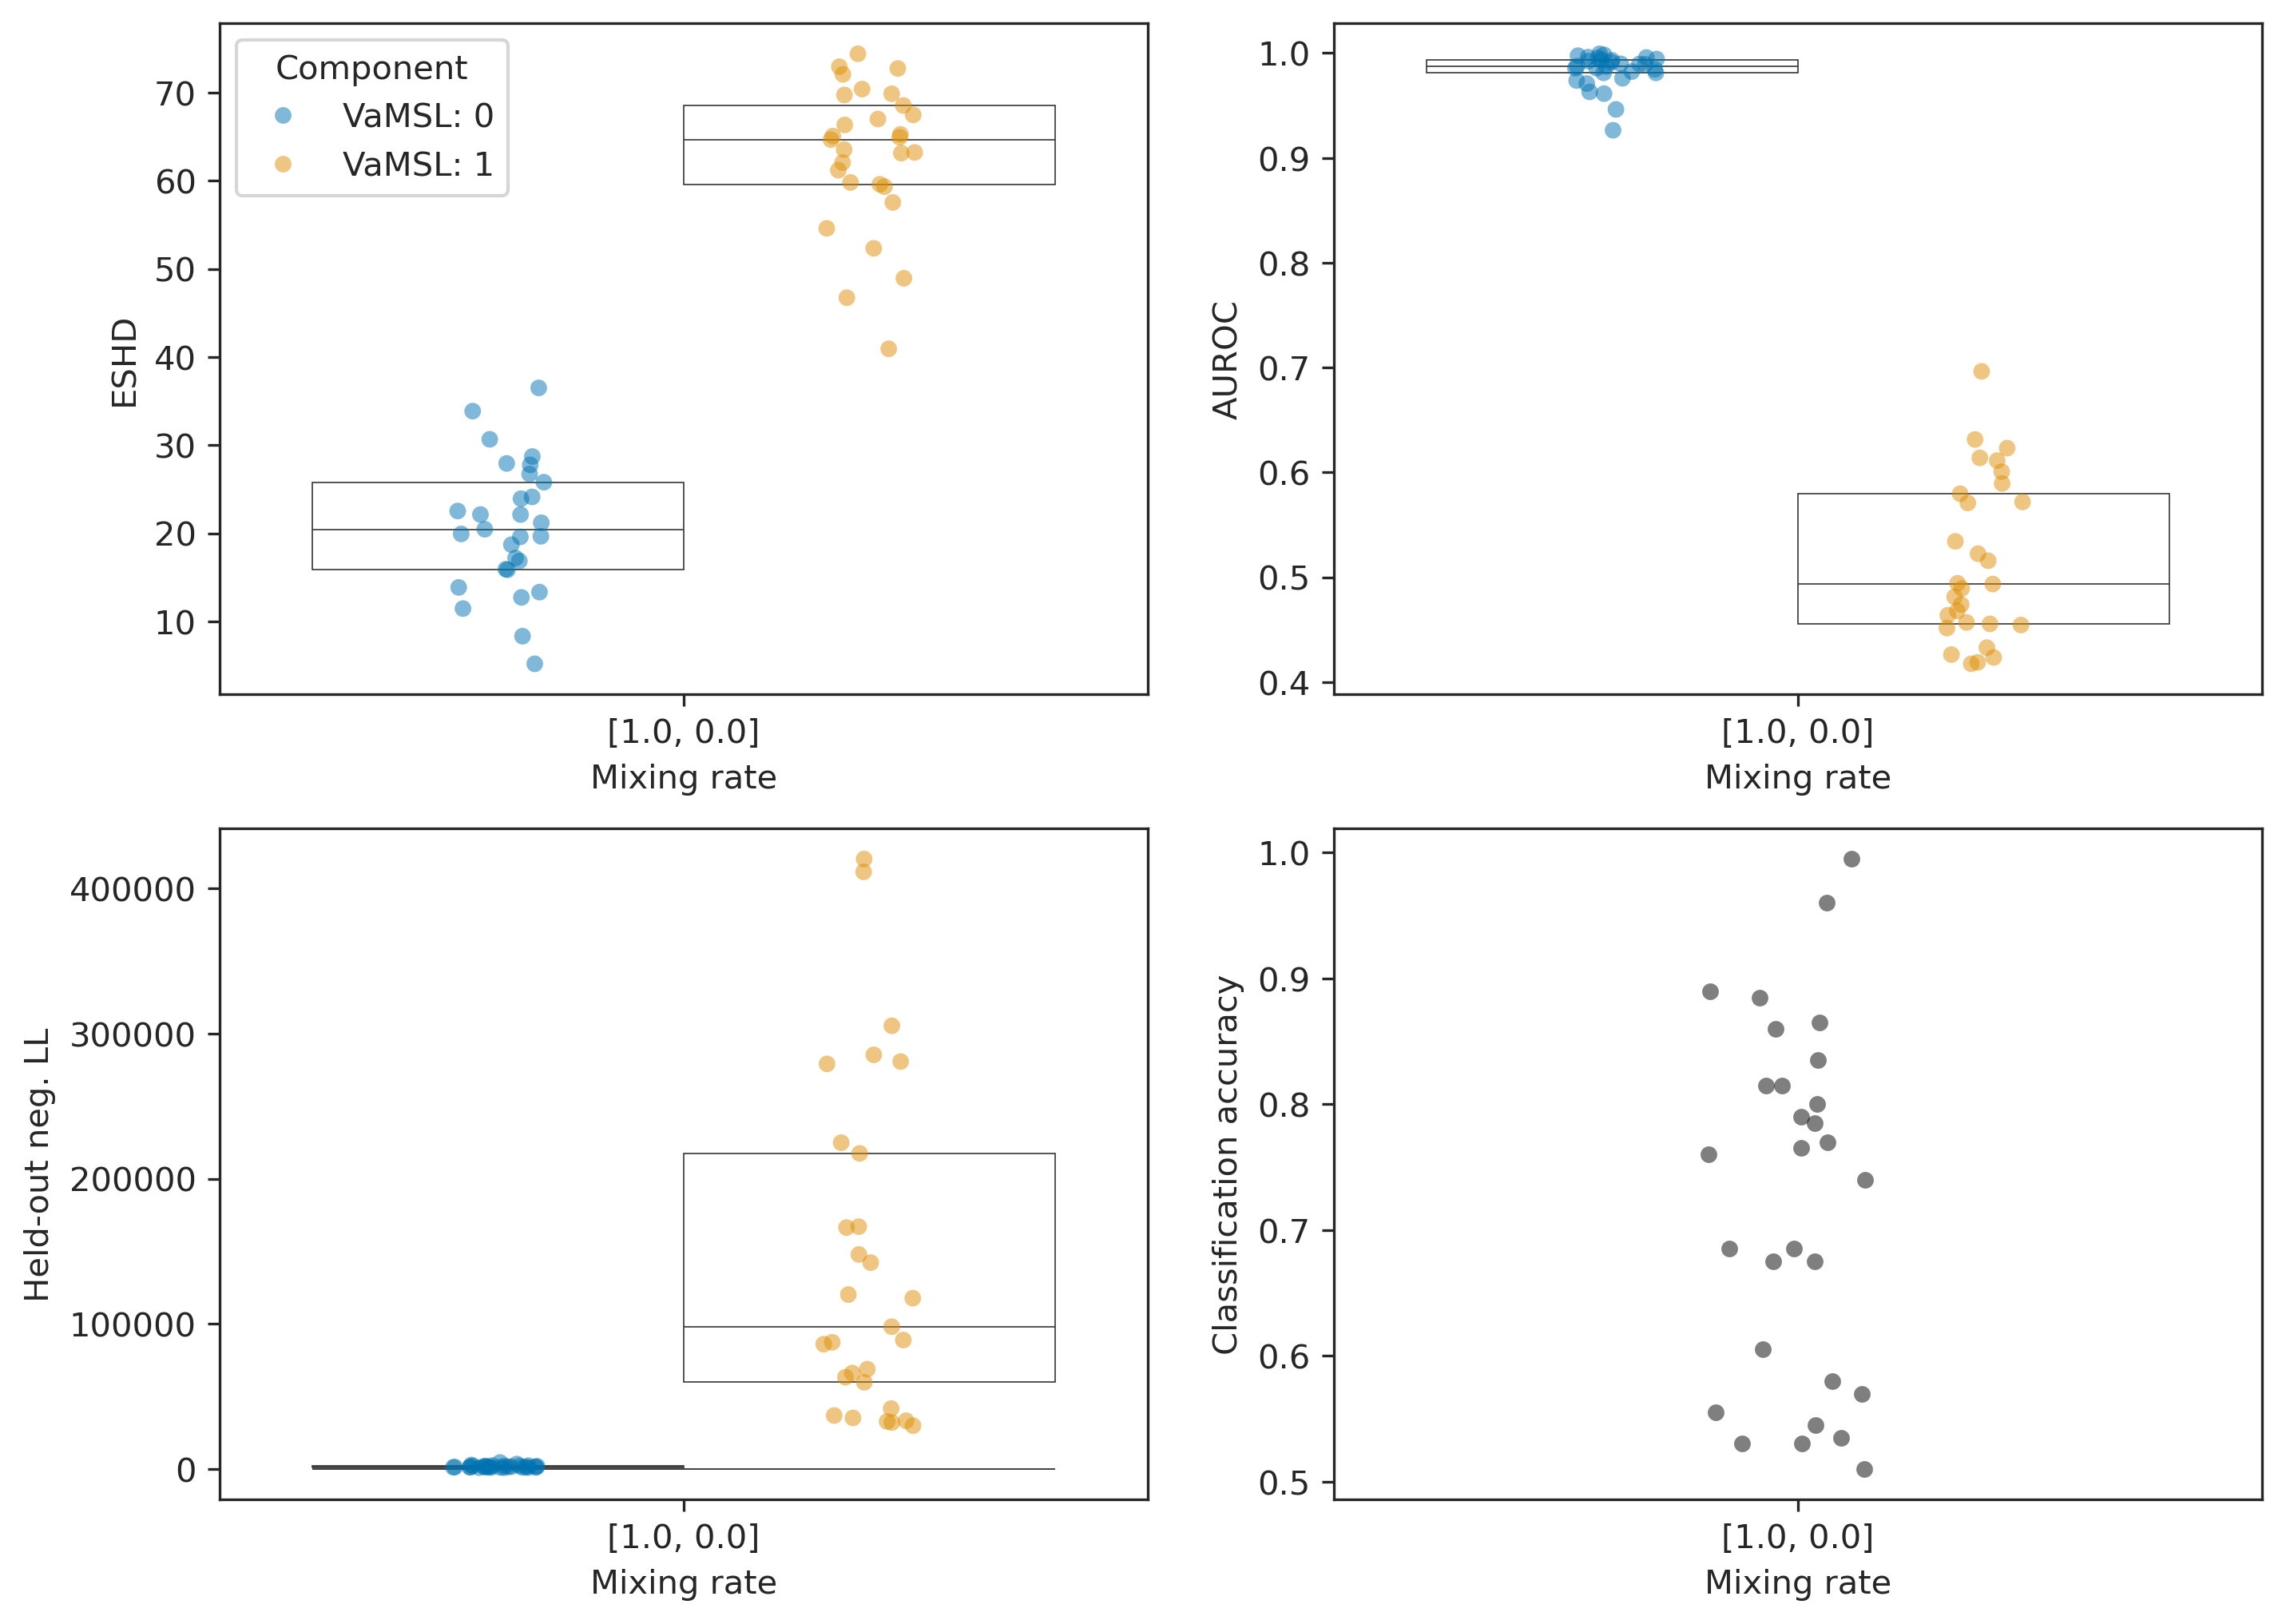

In [331]:
# Choose categorical variable to plot 
category, cat_str = 'mixing_rate', 'Mixing rate'
#category, cat_str = 'graph_type', 'Graph family'
#category, cat_str = 'n_particles', 'Particles per component' 
#category, cat_str = 'n_queries', 'Queries per update'
#category, cat_str = 'expert_reliability', 'Expert reliability'
#category, cat_str = 'init_queries', 'Initial Correct Edges'
#category, cat_str = 'n_vars', 'Variables'
#category, cat_str = 'updates', 'Cluster assignment updates'

# plot all metrics component-wise 
sns.set_style("ticks",{'axes.grid' : False})
fig, axs = plt.subplots(ncols=2,nrows=2, sharey=False, figsize=(11, 8), dpi=300)
for i, plot_metric, plot_metric_str in [((0,0), eshds, 'ESHD'), ((0,1), aurocs, 'AUROC'),((1,0), ho_neglls, 'Held-out neg. LL')]:
    #  Create array with metric results experiment- and component-wise (I'm so sorry)
    cat_metrics = [[[('VaMSL', str(experiment_settings[i_experiment][category]), 'VaMSL: '+ str(component), metric) for component, metric in enumerate(metric_pair)] for metric_pair in plot_metric[i_metrics]] for i_metrics, i_experiment in enumerate(exp_indices)] 
    flatten = lambda xss: [x for xs in xss for x in xs]
    cat_metrics = flatten(flatten(cat_metrics))
    cat_metrics = np.array(cat_metrics)

    # Convert array to data frame and post process
    df_metrics = pd.DataFrame(cat_metrics, columns=['Model', cat_str, 'Component', plot_metric_str])
    df_metrics[plot_metric_str] = df_metrics[plot_metric_str].apply(lambda x : float(x))
    #df = df_metrics.round({plot_metric_str: 2})

    if i == (0,0):
        vamsl_df = df_metrics
    else:
        vamsl_df = pd.concat([vamsl_df , df_metrics[plot_metric_str]], axis=1)
        
    if True: # False to turn of fancy layout and see boxplots
        # plot metric
        palette="colorblind"
        sns.boxplot(data=df_metrics, x=cat_str, y=plot_metric_str, ax=axs[i],
                    hue="Component", palette=palette, 
                    boxprops={'facecolor':'None'}, 
                    whiskerprops={'linewidth':0}, linewidth=0.4, legend=False,
                    showfliers=False, showcaps=False)
        sns.stripplot(data=df_metrics, x=cat_str, y=plot_metric_str, ax=axs[i],
                      hue="Component",  palette=palette,
                      dodge=True, alpha=0.5, legend=True,)
        sns.pointplot(data=df_metrics, x=cat_str, y=plot_metric_str, ax=axs[i],
                      hue="Component",  palette=palette, dodge=.4, 
                      linestyle="none",
                      errorbar=None, marker="_", markersize=0, markeredgewidth=0, legend=False)
        #sns.despine(top=True, left=True, bottom=False, right=True, ax=axs[i])
        #axs[i].yaxis.set_tick_params(width = 0)
        if not i == (0,0):
            axs[i].get_legend().remove()
    else:
         sns.boxplot(data=df_metrics, x=cat_str, y=plot_metric_str, ax=axs[i])

# plot accuracy 
plot_metric_str = "Classification accuracy"
acc_metrics = [[('VaMSL', str(experiment_settings[run_i][category]), acc[0]) for i, acc in enumerate(accuracies[run_i])] for run_i in range(len(smallest_values_ids))] 
accuracy_df = pd.DataFrame(flatten(acc_metrics), columns=['Model', cat_str, plot_metric_str])
accuracy_df[plot_metric_str] = accuracy_df[plot_metric_str].apply(lambda x : float(x))
#accuracy_df = accuracy_df.round({plot_metric_str: 2})
sns.boxplot(data=accuracy_df, x=cat_str, y=plot_metric_str, ax=axs[i],
            boxprops={'facecolor':'None'}, whiskerprops={'linewidth':0}, 
            linewidth=0.4, legend=False, showfliers=False, showcaps=False)
sns.stripplot(data=accuracy_df, x=cat_str, y=plot_metric_str, ax=axs[1,1],
              dodge=True, alpha=0.5, legend=True, color='black')
#sns.despine(top=True, left=True, bottom=False, right=True, ax=axs[1,1])
#axs[1,1].yaxis.set_tick_params(width = 0)

#plt.savefig(f'figures/{experiment_settings_filename[:-5]}' +'.png')
#plt.savefig(f'figures/{experiment_settings_filename[:-5]}' +f'_{k}_best.png')
_=plt.show

### Plot DiBS results

In [253]:
dibs_folder = 'experiment_results_dibs/'
metrics_and_indices = pickle.load(open(dibs_folder + experiment_settings_filename[:-5]+'_metrics.p', "rb"))
# Metrics of shape [experiments, 4, n_runs, component] (four metrics)
metrics, exp_indices = metrics_and_indices[0], metrics_and_indices[1]
print(f'Number of experiments:{exp_indices}')

# [experiments, n_runs, component]
eshds = [metrics[i][0] for i in range(len(exp_indices))] 
aurocs = [metrics[i][1] for i in range(len(exp_indices))] 
ho_neglls = [metrics[i][2] for i in range(len(exp_indices))] 

Number of experiments:[0, 1, 2]


In [254]:
metrics = ho_neglls

k = k
#k = 10# choose k best experiments from each run
smallest_values_ids = []
for metric in metrics:
    exp = np.array([sum([float(val) for val in vals]) for vals in metric])
    idx = np.argpartition(exp, k)
    smallest_values_ids.append(idx[:k])

eshds = [eshds[exp_i][smallest_values_ids[exp_i]] for exp_i in range(len(eshds))] 
aurocs = [aurocs[exp_i][smallest_values_ids[exp_i]] for exp_i in range(len(eshds))] 
ho_neglls = [ho_neglls[exp_i][smallest_values_ids[exp_i]] for exp_i in range(len(eshds))] 

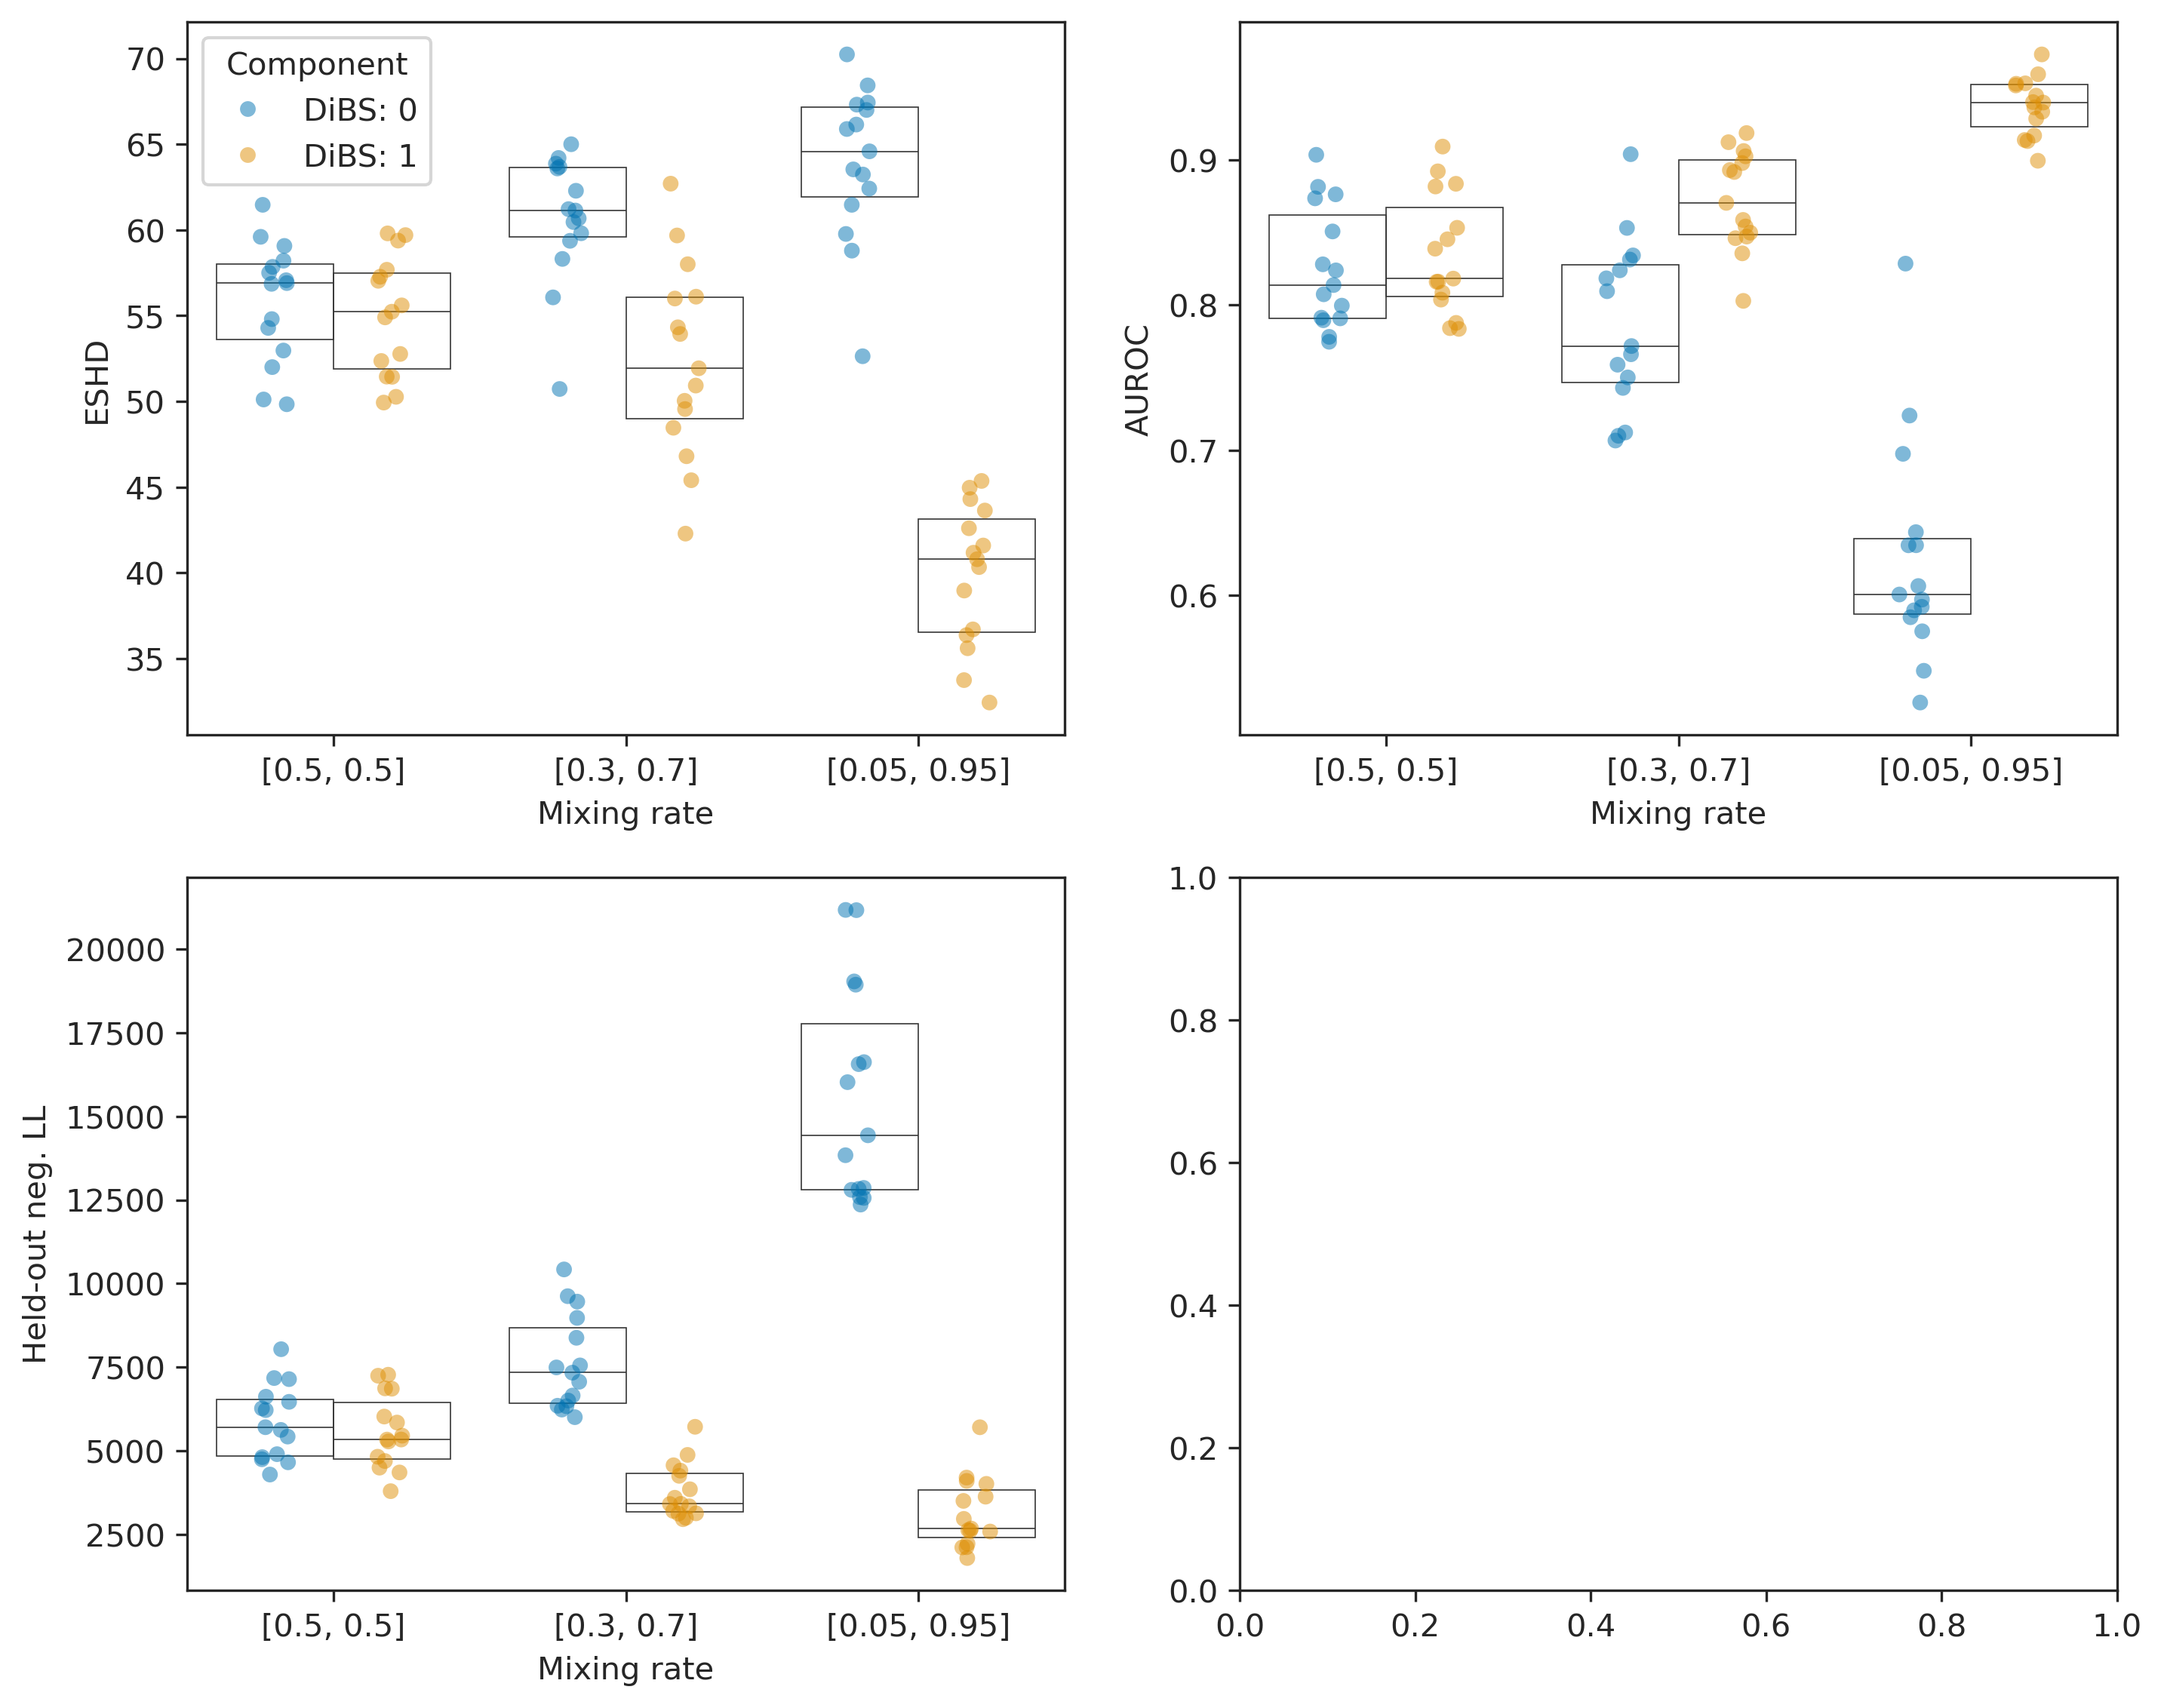

In [255]:
# Choose categorical variable to plot 
category, cat_str = 'mixing_rate', 'Mixing rate'
#category, cat_str = 'graph_type', 'Graph family'
#category, cat_str = 'n_particles', 'Particles per component' 
#category, cat_str = 'n_queries', 'Queries per update'
#category, cat_str = 'expert_reliability', 'Expert reliability'
#category, cat_str = 'init_queries', 'Initial Correct Edges'
#category, cat_str = 'n_vars', 'Variables'
#category, cat_str = 'updates', 'Cluster assignment updates'

# plot all metrics component-wise 
sns.set_style("ticks",{'axes.grid' : False})
fig, axs = plt.subplots(ncols=2,nrows=2, sharey=False, figsize=(11, 9), dpi=300)
for i, plot_metric, plot_metric_str in [((0,0), eshds, 'ESHD'), ((0,1), aurocs, 'AUROC'),((1,0), ho_neglls, 'Held-out neg. LL')]:
    #  Create array with metric results experiment- and component-wise (I'm so sorry)
    cat_metrics = [[[('DiBS', str(experiment_settings[i_experiment][category]), 'DiBS: '+str(component), metric) for component, metric in enumerate(metric_pair)] for metric_pair in plot_metric[i_metrics]] for i_metrics, i_experiment in enumerate(exp_indices)] 
    flatten = lambda xss: [x for xs in xss for x in xs]
    cat_metrics = flatten(flatten(cat_metrics))
    cat_metrics = np.array(cat_metrics)

    # Convert array to data frame and post process
    dibs_df_metrics = pd.DataFrame(cat_metrics, columns=['Model', cat_str, 'Component', plot_metric_str])
    dibs_df_metrics[plot_metric_str] = dibs_df_metrics[plot_metric_str].apply(lambda x : float(x))

    if i == (0,0):
        dibs_df = dibs_df_metrics
    else:
        dibs_df = pd.concat([dibs_df , dibs_df_metrics[plot_metric_str]], axis=1)
    
    if True: # False to turn of fancy layout and see boxplots
        # plot metric
        palette="colorblind"
        sns.boxplot(data=dibs_df_metrics, x=cat_str, y=plot_metric_str, ax=axs[i],
                    hue="Component", palette=palette, 
                    boxprops={'facecolor':'None'}, 
                    whiskerprops={'linewidth':0}, linewidth=0.4, legend=False,
                    showfliers=False, showcaps=False)
        sns.stripplot(data=dibs_df_metrics, x=cat_str, y=plot_metric_str, ax=axs[i],
                      hue="Component",  palette=palette,
                      dodge=True, alpha=0.5, legend=True,)
        sns.pointplot(data=dibs_df_metrics, x=cat_str, y=plot_metric_str, ax=axs[i],
                      hue="Component",  palette=palette, dodge=.4, 
                      linestyle="none",
                      errorbar=None, marker="_", markersize=0, markeredgewidth=0, legend=False)
        #sns.despine(top=True, left=True, bottom=False, right=True, ax=axs[i])
        #axs[i].yaxis.set_tick_params(width = 0)
        if not i == (0,0):
            axs[i].get_legend().remove()
    else:
         sns.boxplot(data=dibs_df_metrics, x=cat_str, y=plot_metric_str, ax=axs[i])

#plt.savefig(f'figures/{experiment_settings_filename[:-5]}' +'DiBS_attempt.png')
#plt.savefig(f'figures/{experiment_settings_filename[:-5]}' +f'DiBS_attempt_{k}_best.png')
_=plt.show

### Plot VaMSL and DiBS together

In [256]:
vamsl_df.head()

,Model,Mixing rate,Component,ESHD,AUROC,Held-out neg. LL
0,VaMSL,"[0.5, 0.5]",VaMSL: 0,22.066664,0.987082,1687.937256
1,VaMSL,"[0.5, 0.5]",VaMSL: 1,21.285713,0.983173,2006.365601
2,VaMSL,"[0.5, 0.5]",VaMSL: 0,27.153847,0.972712,2134.822266
3,VaMSL,"[0.5, 0.5]",VaMSL: 1,15.799997,0.992555,1633.360962
4,VaMSL,"[0.5, 0.5]",VaMSL: 0,32.384624,0.943303,2422.810791


In [257]:
dibs_df.head()

,Model,Mixing rate,Component,ESHD,AUROC,Held-out neg. LL
0,DiBS,"[0.5, 0.5]",DiBS: 0,59.068974,0.790820,6215.872559
1,DiBS,"[0.5, 0.5]",DiBS: 1,57.034500,0.784082,4352.118652
2,DiBS,"[0.5, 0.5]",DiBS: 0,50.111111,0.903395,5704.864746
3,DiBS,"[0.5, 0.5]",DiBS: 1,51.444454,0.892004,5334.910645
4,DiBS,"[0.5, 0.5]",DiBS: 0,57.066654,0.778088,7174.273926


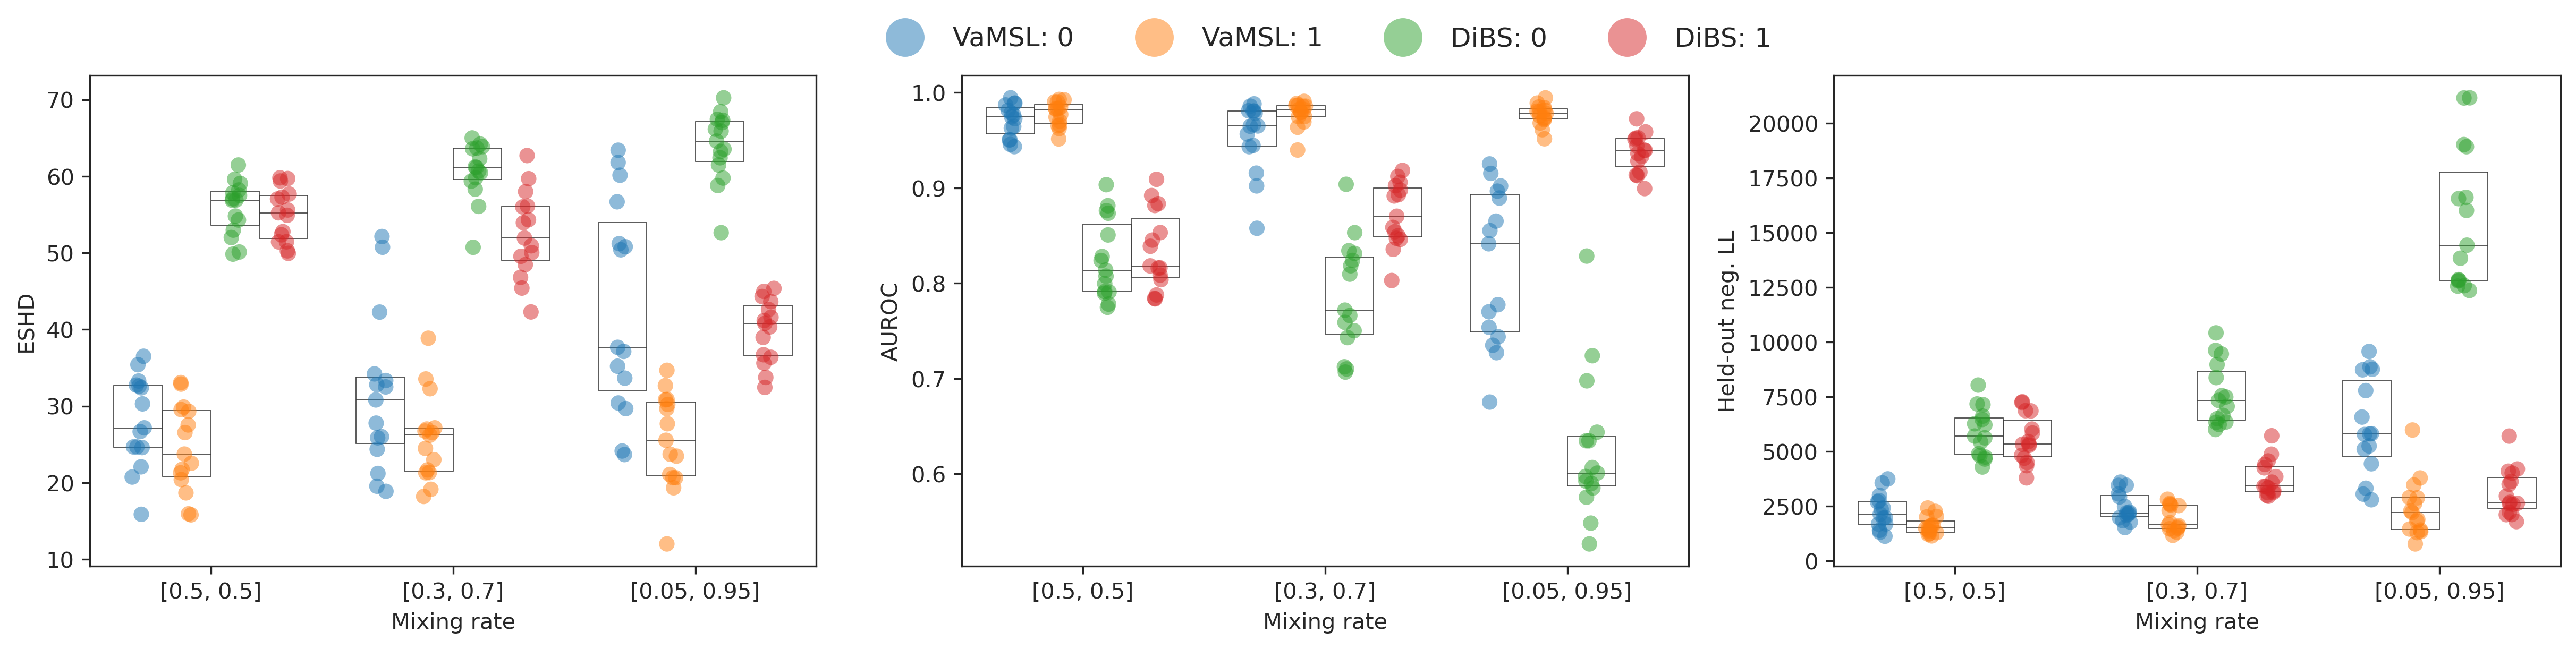

In [319]:
# Choose categorical variable to plot 
category, cat_str = 'mixing_rate', 'Mixing rate'
#category, cat_str = 'graph_type', 'Graph family'
#category, cat_str = 'n_particles', 'Particles per component' 
#category, cat_str = 'n_queries', 'Queries per update'
#category, cat_str = 'expert_reliability', 'Expert reliability'
#category, cat_str = 'init_queries', 'Initial Correct Edges'
#category, cat_str = 'n_vars', 'Variables'
#category, cat_str = 'updates', 'Cluster assignment updates'

# Combine dataframes
combined_df_metrics = pd.concat([vamsl_df, dibs_df], axis=0)

# plot all metrics component-wise 
sns.set_style("ticks",{'axes.grid' : False})
fig, axs = plt.subplots(ncols=3, sharey=False, figsize=(20, 4), dpi=300)
for i, plot_metric_str in [(0, 'ESHD'), (1, 'AUROC'), (2, 'Held-out neg. LL')]:
    if True: # False to turn of fancy layout and see boxplots
        # plot metric
        #sns.color_palette("viridis", as_cmap=True)
        sns.color_palette("cubehelix", as_cmap=True)
        sns.cubehelix_palette(start=.5, rot=-20, as_cmap=True)
        sns.boxplot(data=combined_df_metrics, x=cat_str, y=plot_metric_str, ax=axs[i],
                    hue="Component", boxprops={'facecolor':'None'}, 
                    whiskerprops={'linewidth':0}, linewidth=0.4, legend=False,
                    showfliers=False, showcaps=False)
        sns.stripplot(data=combined_df_metrics, x=cat_str, y=plot_metric_str, ax=axs[i],
                      hue="Component",  size=7,
                      dodge=True, alpha=0.5, legend=True,)
        sns.pointplot(data=combined_df_metrics, x=cat_str, y=plot_metric_str, ax=axs[i],
                      hue="Component",dodge=.2, 
                      linestyle="none",
                      errorbar=None, marker="_", markersize=0, markeredgewidth=0, legend=False)
        #sns.despine(top=True, left=True, bottom=False, right=True, ax=axs[i])
        #axs[i].yaxis.set_tick_params(width = 0)
        if not i == 1:
            axs[i].get_legend().remove()
        else:
            sns.move_legend(axs[i], "lower center",
                            #bbox_to_anchor=(.5, -0.3), ncol=4,
                            bbox_to_anchor=(.5, 1.0), ncol=4, 
                            title=None, frameon=False,
                            fontsize=12, markerscale=2.5)
    else:
         sns.catplot(data=combined_df_metrics, x=cat_str, y=plot_metric_str, 
                     hue="Component", col='Model', ax=axs[i])

#plt.legend(title = "Sources") 
#plt.title("VaMSL v. DiBS") 

#plt.savefig(f'figures/VaMSLvDiBS_{experiment_settings_filename[:-5]}' +'.png')
plt.savefig(f'figures/VaMSLvDiBS_{experiment_settings_filename[:-5]}' +f'_{k}_best.png')
_=plt.show

In [79]:
N = 10000
alphas = [423, 345]
samples = np.random.dirichlet(alphas, size=N)

print(np.log(alphas[0]))
print(f'exact: {digamma(alphas[0])  - digamma(np.sum(alphas))}')

from scipy.special import digamma
s = 0
for sample in samples:
    s += np.log(sample[0])

print(f'Monte Carlo estimae: {s/N}')

6.0473721790462776
exact: -0.5969488699804151
Monte Carlo estimae: -0.5973047077809899
